# LSTM 2

- Aspect를 속성카테고리로 변환하여 분류하는 모델
- SentimentText를 X로, Aspect를 y로 학습시킨 모델(Input_length=27)
- 모델 학습 accuracy: 0.9494 - val_accuracy: 0.9295
- SentimentText, RawText로 테스트: 정확도 92.80%, 
<br>  (원인:)
- SentimentText 학습모델의 Input_length를 42로 늘려서 Remodeling
- 모델 학습 accuracy: 
- 테스트 : 정확도 SentimentText: 43.87%, RawText: 23.38%

## Set

In [2]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib
import platform
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## Load Data

### garments

In [3]:
path = "../../data/raw/"
df_garments = pd.read_csv(path+"garments.csv", sep = ',', encoding = 'utf-8', header = 0)
df_garments.head()

,Index,RawText,Source,Domain,MainCategory,ProductName,ReviewScore,Syllable,Word,RDate,GeneralPolarity,Aspect,SentimentText,SentimentWord,SentimentPolarity
0,128481,아들에게 선물했는데 불편하고 활동하기 안좋다고 잘 안입고 다니네요,쇼핑몰,패션,남성의류,OO 남성 매** 데님 3종,100,37,8,20180626,-1.0,착용감,불편하고,1,-1
1,128481,아들에게 선물했는데 불편하고 활동하기 안좋다고 잘 안입고 다니네요,쇼핑몰,패션,남성의류,OO 남성 매** 데님 3종,100,37,8,20180626,-1.0,착용감,활동하기 안좋다고 잘 안입고 다니네요,5,-1
2,128483,울아들이입어보고너무불편하다고상품이별로래요. 불편해서자주입을것같지는 않데요.,쇼핑몰,패션,남성의류,OO 남성 매** 데님 3종,100,41,3,20180321,-1.0,착용감,너무불편하다고상품이별로래요.,1,-1
3,128483,울아들이입어보고너무불편하다고상품이별로래요. 불편해서자주입을것같지는 않데요.,쇼핑몰,패션,남성의류,OO 남성 매** 데님 3종,100,41,3,20180321,-1.0,착용감,불편해서자주입을것같지는 않데요.,2,-1
4,128484,이번에구매한데님은사이즈가잘맞네요 색상구성도괜찮고맘에든답니다 잘입겠습니다,쇼핑몰,패션,남성의류,OO 남성 매** 데님 3종,100,39,3,20180315,1.0,사이즈,사이즈가잘맞네요,1,1


In [4]:
df_garments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152143 entries, 0 to 152142
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Index              152143 non-null  int64  
 1   RawText            152143 non-null  object 
 2   Source             152143 non-null  object 
 3   Domain             152143 non-null  object 
 4   MainCategory       152143 non-null  object 
 5   ProductName        152125 non-null  object 
 6   ReviewScore        152143 non-null  int64  
 7   Syllable           152143 non-null  int64  
 8   Word               152143 non-null  int64  
 9   RDate              152143 non-null  int64  
 10  GeneralPolarity    149774 non-null  float64
 11  Aspect             152143 non-null  object 
 12  SentimentText      152143 non-null  object 
 13  SentimentWord      152143 non-null  int64  
 14  SentimentPolarity  152143 non-null  int64  
dtypes: float64(1), int64(7), object(7)
memory usage: 17

In [5]:
df_garments['Aspect'].nunique()

27

In [6]:
df_garments['Aspect'].unique()

array(['착용감', '사이즈', '색상', '핏', '신축성', '마감', '가격', '디자인', '품질', '제품구성',
       '두께', '기능', '무게', '길이', '소재', '활용성', '촉감', '냄새', '사용성/편의성', '내구성',
       '기능성', '사이즈/폭/길이/두께', '수납', '치수/사이즈', '착화감', '사용성', '굽'],
      dtype=object)

In [7]:
df_garments['Aspect'].value_counts()

디자인            16353
사이즈            14163
가격             13616
품질             11799
착화감            10667
기능             10492
소재             10312
색상              8965
착용감             8154
치수/사이즈          5985
무게              5664
핏               5621
길이              4305
신축성             4228
두께              3924
활용성             3368
촉감              2499
제품구성            1811
기능성             1810
사이즈/폭/길이/두께     1712
사용성             1545
마감              1517
사용성/편의성         1154
내구성             1016
굽                674
냄새               524
수납               265
Name: Aspect, dtype: int64

## 속성카테고리 학습 (SentimentText to Category)

### 패션 garments

Category 추가

In [11]:
df_garments = df_garments.dropna()
df_garments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149756 entries, 0 to 152142
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Index              149756 non-null  int64  
 1   RawText            149756 non-null  object 
 2   Source             149756 non-null  object 
 3   Domain             149756 non-null  object 
 4   MainCategory       149756 non-null  object 
 5   ProductName        149756 non-null  object 
 6   ReviewScore        149756 non-null  int64  
 7   Syllable           149756 non-null  int64  
 8   Word               149756 non-null  int64  
 9   RDate              149756 non-null  int64  
 10  GeneralPolarity    149756 non-null  float64
 11  Aspect             149756 non-null  object 
 12  SentimentText      149756 non-null  object 
 13  SentimentWord      149756 non-null  int64  
 14  SentimentPolarity  149756 non-null  int64  
dtypes: float64(1), int64(7), object(7)
memory usage: 18

In [12]:
def compress_category(x):
    categories = {
        "사이즈": ["사이즈", "핏", "두께", "길이", "사이즈/폭/길이/두께", "치수/사이즈", "굽"],
        "디자인": ["색상", "디자인"],
        "품질": ["마감", "품질", "소재", "촉감", "냄새", "내구성"],
        "사용성": ["사용성/편의성", "사용성", "수납", "활용성", "제품구성", "무게", "신축성", "기능", "기능성", "착화감", "착용감"],
        "가격": ["가격"]
    }

    for category, detail in categories.items():
        if x in detail:
            return category

compressed_categories = df_garments["Aspect"].map(compress_category)
compressed_categories.value_counts()

사용성    48446
사이즈    35605
품질     27219
디자인    25036
가격     13450
Name: Aspect, dtype: int64

In [13]:
len(compressed_categories)

149756

In [15]:
df_garments["Category"] = compressed_categories
df_garments[:4]

,Index,RawText,Source,Domain,MainCategory,ProductName,ReviewScore,Syllable,Word,RDate,GeneralPolarity,Aspect,SentimentText,SentimentWord,SentimentPolarity,Category
0,128481,아들에게 선물했는데 불편하고 활동하기 안좋다고 잘 안입고 다니네요,쇼핑몰,패션,남성의류,OO 남성 매** 데님 3종,100,37,8,20180626,-1.0,착용감,불편하고,1,-1,사용성
1,128481,아들에게 선물했는데 불편하고 활동하기 안좋다고 잘 안입고 다니네요,쇼핑몰,패션,남성의류,OO 남성 매** 데님 3종,100,37,8,20180626,-1.0,착용감,활동하기 안좋다고 잘 안입고 다니네요,5,-1,사용성
2,128483,울아들이입어보고너무불편하다고상품이별로래요. 불편해서자주입을것같지는 않데요.,쇼핑몰,패션,남성의류,OO 남성 매** 데님 3종,100,41,3,20180321,-1.0,착용감,너무불편하다고상품이별로래요.,1,-1,사용성
3,128483,울아들이입어보고너무불편하다고상품이별로래요. 불편해서자주입을것같지는 않데요.,쇼핑몰,패션,남성의류,OO 남성 매** 데님 3종,100,41,3,20180321,-1.0,착용감,불편해서자주입을것같지는 않데요.,2,-1,사용성


In [16]:
df_garments['Category'].value_counts()

사용성    48446
사이즈    35605
품질     27219
디자인    25036
가격     13450
Name: Category, dtype: int64

In [17]:
target_df = df_garments

In [18]:
label_encoder = LabelEncoder()
enc_data = label_encoder.fit_transform(target_df['Category'])
num_labels = len(set(enc_data))
num_labels

5

In [19]:
X, y = target_df.loc[:, "SentimentText"].to_list(), enc_data

In [20]:
X_train_SC, X_test_SC, y_train_SC, y_test_SC = train_test_split(X, y, test_size=0.2, random_state=88)

In [21]:
X_train_SC[:4], len(X_train_SC)

(['디자인도 안이쁘더라구요~', '편하게 따로 또 같이 입기좋아요 ', '디자인까지 다 마음에 듭니다', '넘 이쁘구 '], 119804)

In [22]:
y_train_SC[:4], len(y_train_SC)

(array([1, 2, 1, 1]), 119804)

Tokenization

In [24]:
# Tokenization
def preprocessing(rawtext,okt,stem=False,remove_stopwords=False,stopwords=[]):
    # 1. 한글 및 공백 제외한 문자 모두 제거 
    rawtext = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]','',rawtext)
    rawtext = re.sub(r"[^가-힣A-Za-z)-9(),!?\'\`]", " ", rawtext)
    # 2. Okt 객체를 활용하여 형태소 단어로 나눔 / 어간 추출 (선택)
    word_text = okt.morphs(rawtext,stem=False)

    if stem:
        word_text = okt.morphs(rawtext,stem=True)
        
        if remove_stopwords:
            # 3. 불용어 제거 (선택)
            word_text = [token for token in word_text if not token in stopwords]          
        return word_text
        
    return word_text

In [25]:
okt = Okt()
stopwords = ['은','는','이','가','하','아','것','들','의','있','되','수','보','주','등','한']

In [27]:
# preprocessing
clean_train_review_SC = []
clean_test_review_SC = []

for SentimentText in X_train_SC:
    clean_train_review_SC.append(preprocessing(SentimentText,okt,stem=True,remove_stopwords=False,stopwords=stopwords))
    
for SentimentText in X_test_SC:
    clean_test_review_SC.append(preprocessing(SentimentText,okt,stem=True,remove_stopwords=False,stopwords=stopwords))

clean_train_review_SC[:4]

[['디자인', '도', '안', '이쁘다'],
 ['편하다', '따로', '또', '같이', '입다', '좋다'],
 ['디자인', '까지', '다', '마음', '에', '듭니', '다'],
 ['넘다', '이쁘다']]

In [29]:
# 토큰화 후 문장별 토큰 수 탐색
tokens_len_SC = [len(tokens) for tokens in clean_train_review_SC]
df_tokens_len_SC = pd.DataFrame(tokens_len_SC, columns=['Token Count'])
df_tokens_len_SC.describe()

,Token Count
count,119804.000000
mean,5.136389
std,2.872032
min,0.000000
25%,3.000000
50%,5.000000
75%,7.000000
max,27.000000


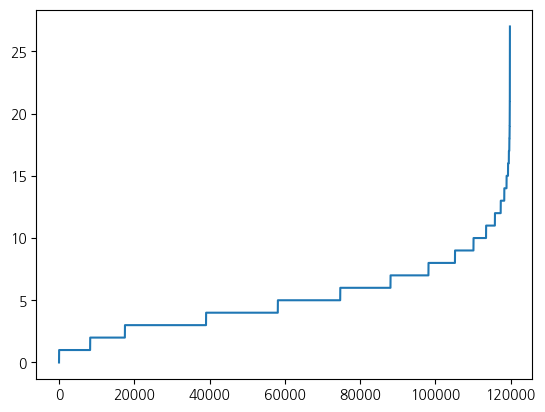

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline 

tokens_len_SC.sort()
plt.plot(tokens_len_SC)
plt.show()

In [31]:
# 토큰화 후 문장별 토큰 수 탐색
tokens_len_SC_t = [len(tokens) for tokens in clean_test_review_SC]
df_tokens_len_SC_t = pd.DataFrame(tokens_len_SC_t, columns=['Token Count'])
df_tokens_len_SC_t.describe()

,Token Count
count,29952.000000
mean,5.130342
std,2.868497
min,1.000000
25%,3.000000
50%,5.000000
75%,7.000000
max,26.000000


In [32]:
max_sequence_length = 27
print(sum([int(l<=max_sequence_length) for l in tokens_len_SC]))

119804


In [33]:
# 토큰 수 컨트롤
modified_clean_train_review_SC = [tokens[:max_sequence_length] for tokens in clean_train_review_SC]
modified_clean_test_review_SC = [tokens[:max_sequence_length] for tokens in clean_test_review_SC]

In [34]:
# 정수 인코딩 및 시퀀스화, 패딩
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(modified_clean_train_review_SC)

X_train_SC = tokenizer.texts_to_sequences(modified_clean_train_review_SC)
X_train_SC = pad_sequences(X_train_SC, maxlen=max_sequence_length, padding='post')

X_test_SC = tokenizer.texts_to_sequences(modified_clean_test_review_SC)
X_test_SC = pad_sequences(X_test_SC, maxlen=max_sequence_length, padding ='post') 

print(X_train_SC[:5])

[[  10    3   54   24    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   7  812  500  358    9    2    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]
 [  10  134   28   93    5  146   28    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]
 [  41   24    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   8    3  161  163    5   73    4   31 6179   39    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [35]:
# 모델 훈련
model_SC = tf.keras.Sequential([
    tf.keras.layers.Embedding(20000,300, input_length=max_sequence_length),
    tf.keras.layers.LSTM(units=50),
    tf.keras.layers.Dense(5, activation='softmax')
])

model_SC.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
model_SC.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 27, 300)           6000000   
                                                                 
 lstm (LSTM)                 (None, 50)                70200     
                                                                 
 dense (Dense)               (None, 5)                 255       
                                                                 
Total params: 6070455 (23.16 MB)
Trainable params: 6070455 (23.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
# 학습
history = model_SC.fit(X_train_SC, y_train_SC, epochs=3, batch_size=128, validation_split=0.2)

Epoch 1/3
749/749 [==============================] - 116s 149ms/step - loss: 0.4699 - accuracy: 0.8287 - val_loss: 0.2452 - val_accuracy: 0.9235
Epoch 2/3
749/749 [==============================] - 122s 163ms/step - loss: 0.1942 - accuracy: 0.9387 - val_loss: 0.2248 - val_accuracy: 0.9287
Epoch 3/3
749/749 [==============================] - 116s 155ms/step - loss: 0.1561 - accuracy: 0.9494 - val_loss: 0.2239 - val_accuracy: 0.9295


#### Test 1 (SentimentText to Category)

In [37]:
# 테스트 데이터 값 예측
prediction_SC = model_SC.predict(X_test_SC)
prediction_SC[:5]

936/936 [==============================] - 8s 8ms/step


array([[2.2501870e-05, 1.8725049e-03, 1.0831865e-03, 9.9642134e-01,
        6.0056773e-04],
       [8.6377515e-04, 8.5805543e-04, 1.9701661e-03, 1.1587671e-03,
        9.9514920e-01],
       [9.9633324e-01, 4.7752575e-04, 9.8856736e-04, 1.8457389e-04,
        2.0160112e-03],
       [1.6678580e-04, 3.2944730e-04, 9.9691856e-01, 1.5243996e-03,
        1.0609324e-03],
       [1.0230244e-03, 2.9084477e-01, 6.7520583e-01, 2.8613826e-02,
        4.3125148e-03]], dtype=float32)

In [38]:
# 테스트 성능
# 1. prediction 배열에서 큰 값의 인덱스를 구함
predicted_labels_SC = np.argmax(prediction_SC, axis=1)

# 2. 실제 라벨과 예측된 라벨을 사용하여 정확도 계산
accuracy_SC = accuracy_score(y_test_SC, predicted_labels_SC)

# 3. 결과 출력
print(f"테스트 정확도: {accuracy_SC * 100:.2f}%")

테스트 정확도: 92.80%


#### Test 2 (RawText to Category)

In [39]:
X_RC, y = target_df.loc[:, "RawText"].to_list(), enc_data
X_train_RC, X_test_RC, y_train_RC, y_test_RC = train_test_split(X_RC, y, test_size=0.2, random_state=88)

In [40]:
len(X_train_RC), len(X_test_RC)

(119804, 29952)

In [41]:
X_train_RC[:5], y_train_RC[:5]

(['애아빠가 입었는데, 넘 불편해보이고 디자인도 안이쁘더라구요~ 길이도 길고 군대간 아들것도 사놓을랬는데 안되겠어요..',
  '편하게 따로 또 같이 입기좋아요  추울때도 끼워입을수 있고 보풀 좀 납니다',
  '사이즈나 재질 디자인까지 다 마음에 듭니다',
  '대입  딸이랑 함께 신을려구  2개 구매했어요 넘 이쁘구 편하네요 딸도 이쁘다고  좋아합니다',
  '셋트구성도 좋고 제질도 넘 괜찮아서 넘 좋은것같아요 가격도 다른거에 비하면 저렴하게 풀셋트로 이거 한셋트면 여행준비 완료 기분좋은 여행 할 생각에 기분까지 벌써 여행한 느낌이네요 가성비 짱 제품 짱 디자인 제질  구성 모두모두 만족합니다 앞으로 좋은곳으로 이 깨리어로 여행 많이 다녀야겠네요 앞으로 잼나게 여행다니며 살아야겠네요^^~~'],
 array([1, 2, 1, 1, 0]))

In [42]:
X_test_RC[:5], y_test_RC[:5]

(['싸지만 결코 떨어지지않는 퀄리티!! 사이즈도 좋고 부드럽고 좋아요~^^ 무배에 이 가격이면 개득템~ㅋ 선물용으로 재구매 해야겠어요^^',
  '구김이 없다고 들었던거 같은데 구김이 좀 많네요, 구김이 심해 반품하려고 했지만 기간이 지나버려 그냥 입기로 했습니다~',
  '적립금이 이렇게 큰 경우는 처음이었어요. 카드할인으로 할인받고 게다가 적립금까지 하다보니 60만원대에 살수 있었네요. 아직은 더워서 바로 입을수는 없지만 이제 추석 지나고 바람 불어오기 시작하면 바로 입을수 있을것 같아요. 사이즈는 일반적인 사이즈 이고, 색감도 네이비가 젊어보이고 좋은것 같아요. 주말껴서 배송이 조금 늦긴 했지만 그렇다고 그리 늦은것 아닌것 같아요. 잘 입을게요.',
  '우선 편하게 잘맞아서 좋구요 데일리로 잘신고 있어요 발복이 넓은 편인데도  편하네요',
  '가격대비  넘넘 퀄러티 좋구요~ 바지 신축성 짱이예요 .5종 모두  예뻐요 ~감사해요 ~^^'],
 array([3, 4, 0, 2, 2]))

In [43]:
# preprocessing
clean_train_review_RC = []
clean_test_review_RC = []

for RawText in X_train_RC:
    clean_train_review_RC.append(preprocessing(RawText,okt,stem=True,remove_stopwords=False,stopwords=stopwords))
    
for RawText in X_test_RC:
    clean_test_review_RC.append(preprocessing(RawText,okt,stem=True,remove_stopwords=False,stopwords=stopwords))

clean_train_review_RC[:5]

[['애',
  '아빠',
  '가',
  '입다',
  '넘다',
  '불편',
  '해보다',
  '디자인',
  '도',
  '안',
  '이쁘다',
  '길이',
  '도',
  '길다',
  '군대',
  '간',
  '아들',
  '것',
  '도',
  '사다',
  '랬',
  '늘다',
  '안되다'],
 ['편하다',
  '따로',
  '또',
  '같이',
  '입다',
  '좋다',
  '추다',
  '때',
  '도',
  '끼우다',
  '이다',
  '있다',
  '보풀',
  '좀',
  '나다'],
 ['사이즈', '나', '재질', '디자인', '까지', '다', '마음', '에', '듭니', '다'],
 ['대입',
  '딸',
  '이랑',
  '함께',
  '신다',
  '구',
  '개',
  '구매',
  '하다',
  '넘다',
  '이쁘다',
  '편하다',
  '딸도',
  '이쁘다',
  '좋아하다'],
 ['셋트구성',
  '도',
  '좋다',
  '제',
  '질도',
  '넘다',
  '괜찮다',
  '넘다',
  '좋다',
  '것',
  '같다',
  '가격',
  '도',
  '다른',
  '거',
  '에',
  '비',
  '하다',
  '저렴하다',
  '풀셋트',
  '로',
  '이',
  '거',
  '한셋트',
  '면',
  '여행',
  '준비',
  '완료',
  '기분',
  '좋다',
  '여행',
  '하다',
  '생각',
  '에',
  '기분',
  '까지',
  '벌써',
  '여행',
  '한',
  '느끼다',
  '가성',
  '비',
  '짱',
  '제품',
  '짱',
  '디자인',
  '제',
  '질',
  '구성',
  '모두',
  '모두',
  '만족하다',
  '앞',
  '으로',
  '좋다',
  '곳',
  '으로',
  '이',
  '깨다',
  '어로',
  '여행',
  '많이',
  '다니다',
  '앞',
  '으로',
  '재다',

In [44]:
# 토큰화 후 문장별 토큰 수 탐색
tokens_len_RC = [len(tokens) for tokens in clean_test_review_RC]
df_tokens_len_RC = pd.DataFrame(tokens_len_RC, columns=['Token Count'])
df_tokens_len_RC.describe()

,Token Count
count,29952.000000
mean,27.627137
std,17.371473
min,3.000000
25%,16.000000
50%,23.000000
75%,34.000000
max,159.000000


In [46]:
max_sequence_length = 27
print(sum([int(l<=max_sequence_length) for l in tokens_len_RC]))

18880


In [47]:
# 토큰 수 컨트롤
modified_clean_train_review_RC = [tokens[:max_sequence_length] for tokens in clean_train_review_RC]
modified_clean_test_review_RC = [tokens[:max_sequence_length] for tokens in clean_test_review_RC]

In [48]:
# 정수 인코딩 및 시퀀스화, 패딩
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(modified_clean_train_review_RC)

X_train_RC = tokenizer.texts_to_sequences(modified_clean_train_review_RC)
X_train_RC = pad_sequences(X_train_RC, maxlen=max_sequence_length, padding='post')

X_test_RC = tokenizer.texts_to_sequences(modified_clean_test_review_RC)
X_test_RC = pad_sequences(X_test_RC, maxlen=max_sequence_length, padding ='post') 

print(X_train_RC[:5])

[[ 840  671    6    7   46  762  263   14    4   45   29   60    4  230
  5437 1112  213   71    4   49 4568  269  274    0    0    0    0]
 [   8  914  327  312    7    3  259   51    4 1121   17   15  337   23
   212    0    0    0    0    0    0    0    0    0    0    0    0]
 [  10  141  101   14  155   36   98    5  195   36    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]
 [6623  414  280  777   41  174  147   33    2   46   29    8 1966   29
   162    0    0    0    0    0    0    0    0    0    0    0    0]
 [5438    4    3  113  545   46   54   46    3   71   13   11    4  111
   164    5   93    2   43 6140   31    1  164 3376  167  559 1497]]


In [49]:
# 테스트 데이터 값 예측
prediction_RC = model_SC.predict(X_test_RC)
prediction_RC[:5]

936/936 [==============================] - 10s 11ms/step


array([[4.4108140e-03, 3.2411626e-01, 6.1635125e-01, 2.0617370e-02,
        3.4504373e-02],
       [3.3323377e-04, 2.5609590e-02, 2.0375739e-01, 7.6103079e-01,
        9.2689497e-03],
       [5.1219411e-02, 5.7297504e-01, 4.6050306e-02, 5.9854791e-02,
        2.6990044e-01],
       [9.9270272e-01, 4.7249882e-04, 2.1876886e-03, 2.6669010e-04,
        4.3703769e-03],
       [1.1785333e-03, 9.9397320e-01, 7.7282137e-04, 2.0028502e-03,
        2.0726603e-03]], dtype=float32)

In [50]:
# 테스트 성능
# 1. prediction 배열에서 큰 값의 인덱스를 구함
predicted_labels_RC = np.argmax(prediction_RC, axis=1)

# 2. 실제 라벨과 예측된 라벨을 사용하여 정확도 계산
accuracy_RC = accuracy_score(y_test_RC, predicted_labels_RC)

# 3. 결과 출력
print(f"테스트 정확도: {accuracy_RC * 100:.2f}%")

테스트 정확도: 22.68%
